# Eigh is a random function. What's the distribution

In [1]:
import numpy as np
from pathlib import Path
from graspy.plot import pairplot, heatmap
from scipy.sparse.linalg import eigsh
from mapalign import embed

import sys; sys.path.append('../')
from src.tools import get_files, get_latents, align, iterate_align
from src.plotting import visualize_embeddings, make_cbar
from scripts.embed_dmap_affinity import compute_affinity

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

In [34]:
def load_data(source_dir, data, exclude_ids=['073'], key='latent'):
    source_dir = Path(source_dir)
    if data == 'antoine':
        flag = "_emb"
        SOURCE = 'dmap'
        ftype = 'npy'
    elif data == 'gcca':
        flag = "_gcca"
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'svd':
        flag = '_svd'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'dmap':
        flag = '_dmap'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'mase_dmap':
        flag = '_mase_dmap'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'mase':
        flag = '_mase'
        SOURCE = 'gcca'
        ftype = 'h5'
    return get_latents(
        source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, subjects_exclude=exclude_ids, as_groups=False,
        h5_key=key
    )

In [35]:
files = [
    "/mnt/ssd3/ronan/data/raw/n_sub-109_ses-1_task-restingstate.csv",
    "/mnt/ssd3/ronan/data/raw/n_sub-109_ses-1_task-compassion.csv",
    "/mnt/ssd3/ronan/data/raw/n_sub-109_ses-1_task-openmonitoring.csv"
]
X = []
for file in files:
    data = np.genfromtxt(file, delimiter=',')
    data = (data.T - np.nanmean(data, axis = 1)).T
    data = (data.T / np.nanstd(data, axis = 1)).T
    X.append(data)
    del data
X = np.hstack(X)

In [36]:
def compute_diffusion_map(L, alpha=0.5, n_components=None, diffusion_time=0,
                          skip_checks=False, overwrite=False,
                          eigen_solver=None, return_result=False,
                          norm_eigs=True, return_dmap=False):
    """Compute the diffusion maps of a symmetric similarity matrix
        L : matrix N x N
           L is symmetric and L(x, y) >= 0
        alpha: float [0, 1]
            Setting alpha=1 and the diffusion operator approximates the
            Laplace-Beltrami operator. We then recover the Riemannian geometry
            of the data set regardless of the distribution of the points. To
            describe the long-term behavior of the point distribution of a
            system of stochastic differential equations, we can use alpha=0.5
            and the resulting Markov chain approximates the Fokker-Planck
            diffusion. With alpha=0, it reduces to the classical graph Laplacian
            normalization.
        n_components: int
            The number of diffusion map components to return. Due to the
            spectrum decay of the eigenvalues, only a few terms are necessary to
            achieve a given relative accuracy in the sum M^t.
        diffusion_time: float >= 0
            use the diffusion_time (t) step transition matrix M^t
            t not only serves as a time parameter, but also has the dual role of
            scale parameter. One of the main ideas of diffusion framework is
            that running the chain forward in time (taking larger and larger
            powers of M) reveals the geometric structure of X at larger and
            larger scales (the diffusion process).
            t = 0 empirically provides a reasonable balance from a clustering
            perspective. Specifically, the notion of a cluster in the data set
            is quantified as a region in which the probability of escaping this
            region is low (within a certain time t).
        skip_checks: bool
            Avoid expensive pre-checks on input data. The caller has to make
            sure that input data is valid or results will be undefined.
        overwrite: bool
            Optimize memory usage by re-using input matrix L as scratch space.
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Diffusion_map
        [2] Coifman, R.R.; S. Lafon. (2006). "Diffusion maps". Applied and
        Computational Harmonic Analysis 21: 5-30. doi:10.1016/j.acha.2006.04.006
    """

    import numpy as np
    import scipy.sparse as sps

    use_sparse = False
    if sps.issparse(L):
        use_sparse = True

    if not skip_checks:
        if has_sklearn:
            from sklearn.manifold.spectral_embedding_ import _graph_is_connected
            if not _graph_is_connected(L):
                raise ValueError('Graph is disconnected')
        else:
            raise ImportError('Checks require scikit-learn, but not found')

    ndim = L.shape[0]
    if overwrite:
        L_alpha = L
    else:
        L_alpha = L.copy()

    if alpha > 0:
        # Step 2
        d = np.array(L_alpha.sum(axis=1)).flatten()
        d_alpha = np.power(d, -alpha)
        if use_sparse:
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
        else:
            L_alpha = d_alpha[:, np.newaxis] * L_alpha 
            L_alpha = L_alpha * d_alpha[np.newaxis, :]

    # Step 3
    d_alpha = np.power(np.array(L_alpha.sum(axis=1)).flatten(), -1)
    if use_sparse:
        L_alpha.data *= d_alpha[L_alpha.indices]
    else:
        L_alpha = d_alpha[:, np.newaxis] * L_alpha

    M = L_alpha
    if return_dmap:
        return M

    from scipy.sparse.linalg import eigs, eigsh
    if eigen_solver is None:
        eigen_solver = eigs

    # Step 4
    func = eigen_solver
    if n_components is not None:
        lambdas, vectors = func(M, k=n_components + 1)
    else:
        lambdas, vectors = func(M, k=max(2, int(np.sqrt(ndim))))
    del M

    if func == eigsh:
        lambdas = lambdas[::-1]
        vectors = vectors[:, ::-1]
    else:
        lambdas = np.real(lambdas)
        vectors = np.real(vectors)
        lambda_idx = np.argsort(lambdas)[::-1]
        lambdas = lambdas[lambda_idx]
        vectors = vectors[:, lambda_idx]

    return _step_5(lambdas, vectors, ndim, n_components, diffusion_time,
                   return_result, norm_eigs)


def _step_5(lambdas, vectors, ndim, n_components, diffusion_time, return_result, norm_eigs):
    """
    This is a helper function for diffusion map computation.
    The lambdas have been sorted in decreasing order.
    The vectors are ordered according to lambdas.
    """
    if norm_eigs:
        psi = vectors/vectors[:, [0]]
    else:
        psi = vectors
    diffusion_times = diffusion_time
    if diffusion_time == 0:
        diffusion_times = np.exp(1. -  np.log(1 - lambdas[1:])/np.log(lambdas[1:]))
        if norm_eigs:
            lambdas = lambdas[1:] / (1 - lambdas[1:])
    else:
        lambdas = lambdas[1:] ** float(diffusion_time)
    lambda_ratio = lambdas/lambdas[0]
    threshold = max(0.05, lambda_ratio[-1])

    n_components_auto = np.amax(np.nonzero(lambda_ratio > threshold)[0])
    n_components_auto = min(n_components_auto, ndim)
    if n_components is None:
        n_components = n_components_auto
    embedding = psi[:, 1:(n_components + 1)] * lambdas[:n_components][None, :]

    if return_result:
        result = dict(lambdas=lambdas, vectors=vectors,
                      n_components=n_components, diffusion_time=diffusion_times,
                      n_components_auto=n_components_auto)
        return embedding, result
    else:
        return embedding

In [37]:
def run_perc(data, thresh):
    perc_all = np.zeros(data.shape[0])
    for n,i in enumerate(data):
        data[n, i < np.percentile(i, thresh)] = 0.
    for n,i in enumerate(data):
        data[n, i < 0.] = 0.
    return data

K = X
K[np.isnan(K)] = 0.0

A_mA = K - K.mean(1)[:,None]
ssA = (A_mA**2).sum(1)
Asq = np.sqrt(np.dot(ssA[:,None],ssA[None]))
Adot = A_mA.dot(A_mA.T)

K = Adot/Asq
del A_mA, ssA, Asq, Adot
K = run_perc(K, 90)

norm = (K * K).sum(0, keepdims=True) ** .5
K = K.T @ K
aff = K / norm / norm.T

dmap = compute_diffusion_map(aff, alpha = 0.5, n_components=5, skip_checks=True, return_dmap=True)

In [38]:
reps = 100
evalues = []
for _ in range(reps):
    emb, _ = embed.compute_diffusion_map(
        aff, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigsh, return_result=True)
    evals = np.linalg.norm(emb, axis=0)
    evalues.append(evals)
evalues = np.asarray(evalues)

In [39]:
source_dir = '/mnt/ssd3/ronan/data/dmap_antoinne_09-04'
data = 'antoine'
Xs, labels, subjs = load_data(source_dir, data)
print(np.linalg.norm(Xs[1], axis=0))

sort_idx = np.argsort(subjs)[::-1]
Xs = Xs[sort_idx]
labels = labels[sort_idx]
subjs = subjs[sort_idx]
labels_st = [l[0] + ' ' + l[1] for l in labels]
labels_subj_st = [f'{subj}, {l}' for subj,l in zip(subjs, labels_st)]

[252.59346  246.74161  168.04521  123.80227   92.611305]


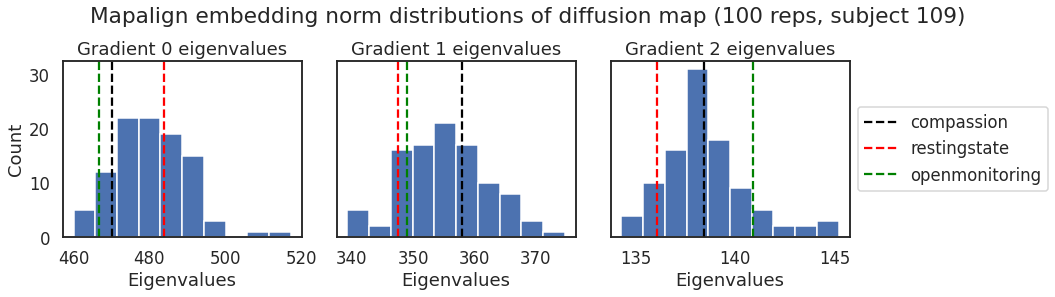

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True)
colors = ['black', 'red', 'green']
for i in range(len(axs)):
    ax = axs[i]
    ax.hist(evalues[:,i])#, label=f'Grad {i} distribution')
    for j in range(3):
        ax.axvline(np.linalg.norm(Xs[j][:, i]), ls='--', c=colors[j], label=labels[j][1])
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Gradient {i} eigenvalues')
    ax.set_xlabel('Eigenvalues')
axs[0].set_ylabel('Count')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.suptitle('Mapalign embedding norm distributions of diffusion map (100 reps, subject 109)', y=1.05)
plt.show()

In [41]:
reps = 100
res_evalues = []
for _ in range(reps):
    emb, res = embed.compute_diffusion_map(
        aff, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigsh, return_result=True)
    evals = res['lambdas']
    res_evalues.append(evals)
res_evalues = np.asarray(res_evalues)

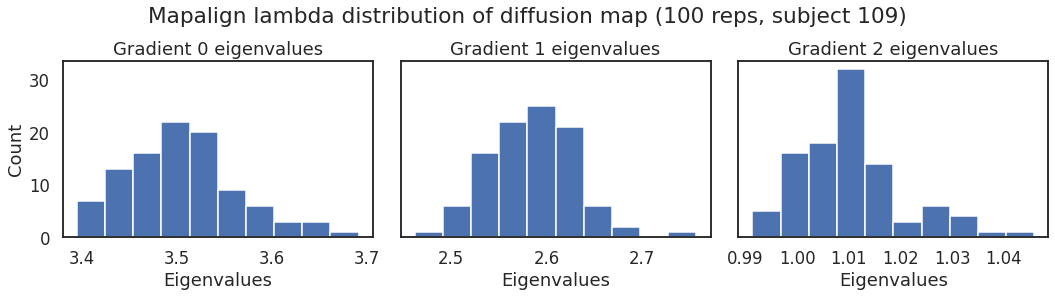

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True)
colors = ['black', 'red', 'green']
for i in range(len(axs)):
    ax = axs[i]
    ax.hist(res_evalues[:,i])#, label=f'Grad {i} distribution')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Gradient {i} eigenvalues')
    ax.set_xlabel('Eigenvalues')
axs[0].set_ylabel('Count')
plt.tight_layout()
plt.suptitle('Mapalign lambda distribution of diffusion map (100 reps, subject 109)', y=1.05)
plt.show()

In [43]:
from joblib import Parallel, delayed
reps = 100
eigsh_evalues = []
eigsh_results = Parallel(n_jobs=25)(delayed(eigsh)(dmap, 4) for _ in range(reps))

In [44]:
eigsh_evalues = np.asarray(list(zip(*eigsh_results))[0])

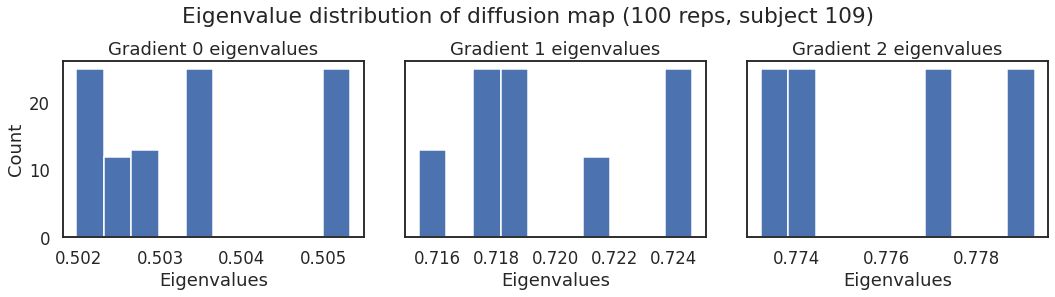

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True)
colors = ['black', 'red', 'green']
for i in range(len(axs)):
    ax = axs[i]
    ax.hist(eigsh_evalues[:,i])#, label=f'Grad {i} distribution')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Gradient {i} eigenvalues')
    ax.set_xlabel('Eigenvalues')
axs[0].set_ylabel('Count')
plt.tight_layout()
plt.suptitle('Eigenvalue distribution of diffusion map (100 reps, subject 109)', y=1.05)
plt.show()

## Checking internal calculation

In [6]:
X = np.genfromtxt("/mnt/ssd3/ronan/data/raw/n_sub-109_ses-1_task-compassion.csv", delimiter=',')
aff = compute_affinity(X, step2=False)

In [7]:
emb, res = embed.compute_diffusion_map(
    aff, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigsh, return_result=True)

In [8]:
np.linalg.norm(emb, axis=0)

array([524.12308563, 296.5732776 , 149.60724214, 112.5735157 ,
        80.69496011])

In [11]:
res.keys()

dict_keys(['lambdas', 'vectors', 'n_components', 'diffusion_time', 'n_components_auto'])

In [12]:
res['lambdas']

array([3.88163263, 2.1483411 , 1.09971398, 0.81091759, 0.5979227 ])

## Without normalization

In [15]:
reps = 100
evalues = []
for _ in range(reps):
    emb, _ = compute_diffusion_map(
        aff, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigsh, return_result=True,
        norm_eigs=False)
    # evals, _ = eigsh(dmap, k=4)
    evals = np.linalg.norm(emb, axis=0)
    evalues.append(evals)
evalues = np.asarray(evalues)

In [16]:
source_dir = '/mnt/ssd3/ronan/data/dmap_antoinne_09-04'
data = 'antoine'
Xs, labels, subjs = load_data(source_dir, data)
print(np.linalg.norm(Xs[1], axis=0))

sort_idx = np.argsort(subjs)[::-1]
Xs = Xs[sort_idx]
labels = labels[sort_idx]
subjs = subjs[sort_idx]
labels_st = [l[0] + ' ' + l[1] for l in labels]
labels_subj_st = [f'{subj}, {l}' for subj,l in zip(subjs, labels_st)]

[252.59346  246.74161  168.04521  123.80227   92.611305]


No handles with labels found to put in legend.


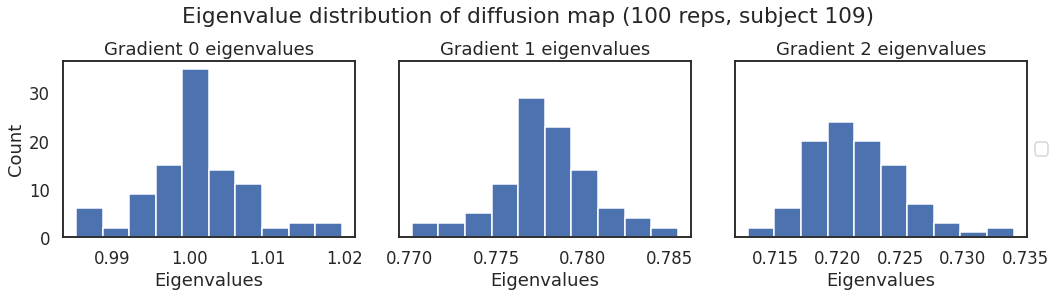

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True)
colors = ['black', 'red', 'green']
for i in range(len(axs)):
    ax = axs[i]
    ax.hist(evalues[:,i])#, label=f'Grad {i} distribution')
    for j in range(3):
        ax.axvline(np.linalg.norm(Xs[j][:, i]), ls='--', c=colors[j], label=labels[j][1])
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Gradient {i} eigenvalues')
    ax.set_xlabel('Eigenvalues')
axs[0].set_ylabel('Count')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.suptitle('Eigenvalue distribution of diffusion map (100 reps, subject 109)', y=1.05)
plt.show()

In [19]:
emb, res = compute_diffusion_map(
        aff, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigsh, return_result=True,
        norm_eigs=False)

In [21]:
res['lambdas'][1] / res['lambdas'][0]

0.7806594703579012

In [22]:
res['vectors']

array([[ 0.00700314, -0.00901045,  0.00123317, -0.01071269, -0.01490667,
         0.01050424],
       [ 0.00731699, -0.007525  ,  0.0016191 , -0.01387947, -0.02707775,
         0.01605882],
       [ 0.00719088, -0.00968615,  0.00612533, -0.00592093,  0.00821711,
        -0.00261834],
       ...,
       [ 0.00734873,  0.00432708,  0.0006949 ,  0.01064447,  0.00467702,
         0.00811044],
       [ 0.00728037, -0.00026906, -0.0048914 ,  0.01487652,  0.00304442,
         0.01098134],
       [ 0.0072447 , -0.00299356, -0.0068746 ,  0.01012662, -0.00113505,
         0.00607546]])

In [25]:
emb[:,0] @ emb[:, 1].T

1.6653345369377348e-16

In [26]:
emb_scaled = emb / emb[:, [0]]
emb_scaled[:,1] @ emb_scaled[:,2].T

12750065.006440502

(array([2394., 2246., 1986., 1665., 1632., 1942., 2106., 1653., 1401.,
        1690.]),
 array([-0.01192376, -0.00940817, -0.00689259, -0.004377  , -0.00186142,
         0.00065417,  0.00316976,  0.00568534,  0.00820093,  0.01071651,
         0.0132321 ]),
 <a list of 10 Patch objects>)

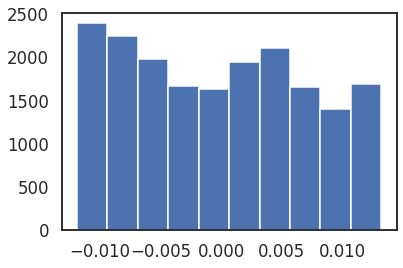

In [27]:
plt.hist(emb[:,0])